# Testing

In [1]:
import torch
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from dataset import get_rays
from rendering import rendering
import torch.nn as nn
from ml_helpers import training
from model import Voxel, NeRF

In [2]:
test_o, test_d, target_px_values = get_rays('bottle')

In [3]:
device = 'cuda'
model = torch.load('model_nerf_bottle')
tn = 8.
tf = 12.
H = 720
W = 1280

C:\Users\patel\AppData\Local\Temp\ipykernel_8120\4206885290.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_nerf_bottle')


In [4]:
def mse2psnr(mse):
    return 20 * np.log10(1 / np.sqrt(mse))

@torch.no_grad()
def test(model, o, d, tn, tf, nb_bins=100, chunk_size=10, target=None):
    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)

    image = []
    for o_batch, d_batch in zip(o, d):
        img_batch = rendering(model, o_batch, d_batch, tn, tf, nb_bins=nb_bins, device=o_batch.device)
        image.append(img_batch)

    image = torch.cat(image)
    image = image.reshape(H, W, 3).data.cpu().numpy()

    if target is not None:
        mse = ((image - target) ** 2).mean()
        psnr = mse2psnr(mse)
        return image, mse, psnr

    return image

In [4]:
import gc
torch.cuda.empty_cache()
gc.collect()

10

In [ ]:
TEST_IMG = 1
img, mse, psnr = test(model, torch.from_numpy(test_o[TEST_IMG]).to(device).float(), torch.from_numpy(test_d[TEST_IMG]).to(device).float(),
                    tn, tf, nb_bins=100, chunk_size=10, target=target_px_values[TEST_IMG].reshape(720, 400, 3))

ValueError: cannot reshape array of size 2764800 into shape (400,400,3)

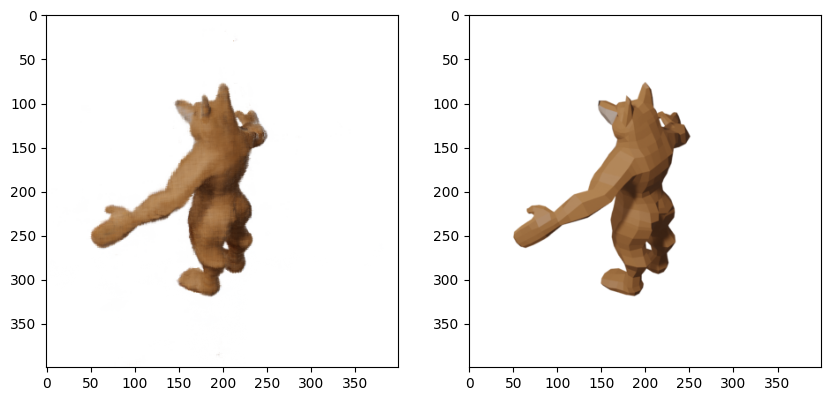

In [43]:
fix, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(target_px_values[TEST_IMG].reshape(400, 400, 3))
plt.show()

In [44]:
mse, psnr

(0.000862208822099558, 30.643875377688907)

# Mesh Extraction

In [7]:
import torch
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from dataset import get_rays
from rendering import rendering
import torch.nn as nn
from ml_helpers import training
from model import Voxel, NeRF
import mcubes
import trimesh

In [9]:
device = 'cuda'
model = torch.load('model_nerf_bottle')
tn = 8.
tf = 12.
H = 720
W = 1280

C:\Users\patel\AppData\Local\Temp\ipykernel_4672\4206885290.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_nerf_bottle')


In [10]:
N = 100
scale = 1.5

x = torch.linspace(-scale, scale, N)
y = torch.linspace(-scale, scale, N)
z = torch.linspace(-scale, scale, N)
x, y, z = torch.meshgrid((x, y, z))

xyz = torch.cat((x.reshape(-1, 1),
                y.reshape(-1, 1),
                z.reshape(-1, 1)), dim=1)

c:\Users\patel\anaconda3\envs\tiai\Lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
with torch.no_grad():
    _, density = model.forward(xyz.to(device), torch.zeros_like(xyz).to(device))

density = density.cpu().numpy().reshape(N, N, N)

In [22]:
vertices, traingles = mcubes.marching_cubes(density, 3 * np.mean(density))

In [21]:
mesh = trimesh.Trimesh(vertices, traingles)
mesh.show()